In [6]:
import pandas as pd

df = pd.read_csv('Carseats.csv')
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [7]:
df['SalesHigh'] = df['Sales'].apply(lambda x: 'Yes' if x >= 8 else 'No')

df.drop('Sales', axis=1, inplace=True)

In [8]:
# One-hot encoding dla zmiennych kategorycznych
df['SalesHigh'] = df['SalesHigh'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df, drop_first=True)

In [9]:
# Podział cechy / etykiety
X = df.drop('SalesHigh', axis=1)
y = df['SalesHigh']

In [10]:
from sklearn.model_selection import train_test_split

# Podział na zbiór treningowy i testowy (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Z podzbioru treningowego wydziel walidacyjny (np. 25% z treningowego)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Trening drzewa decyzyjnego
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Ewaluacja na zbiorze walidacyjnym
y_val_pred = clf.predict(X_val)
print("Results train:")
print(classification_report(y_val, y_val_pred))

Results:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        48
           1       0.58      0.66      0.62        32

    accuracy                           0.68        80
   macro avg       0.67      0.67      0.67        80
weighted avg       0.68      0.68      0.68        80



In [17]:
# Ewaluacja na zbiorze testowym
y_test_pred = clf.predict(X_test)
print("Results test:")
print(classification_report(y_test, y_test_pred))

Results test:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        43
           1       0.69      0.78      0.73        37

    accuracy                           0.74        80
   macro avg       0.74      0.74      0.74        80
weighted avg       0.74      0.74      0.74        80



In [19]:
from sklearn.model_selection import cross_val_score

# 5-krotna walidacja krzyżowa
scores = cross_val_score(clf, X_train_full, y_train_full, cv=5)
print("Mean cross validation:", scores.mean())

Mean cross validation: 0.703125


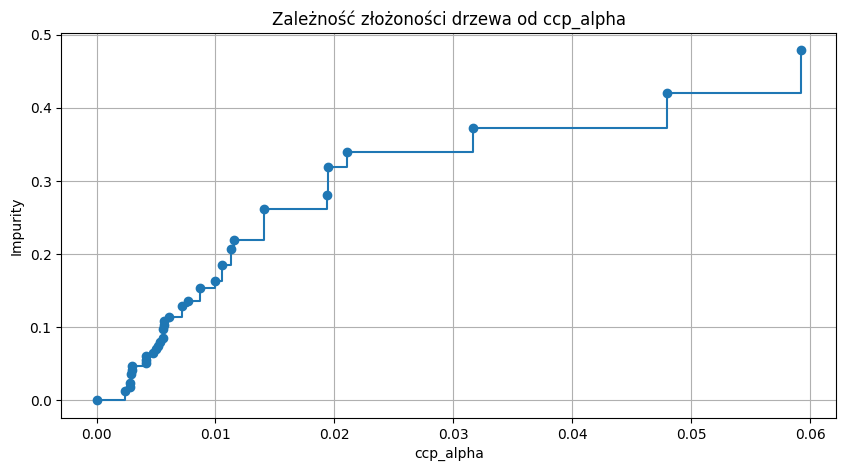

In [20]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

# Bazowy model bez ograniczeń
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train_full, y_train_full)

ccp_alphas = path.ccp_alphas  # Wartości ccp_alpha
impurities = path.impurities  # Odpowiadające im błędy

# Wizualizacja zależności ccp_alpha od impurity
plt.figure(figsize=(10, 5))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Impurity")
plt.title("Zależność złożoności drzewa od ccp_alpha")
plt.grid()
plt.show()

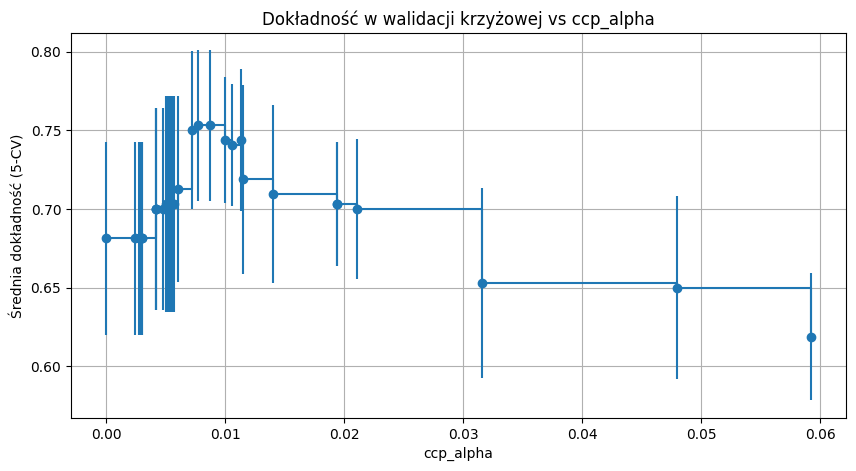

In [21]:
from sklearn.model_selection import cross_val_score

clfs = []
alpha_loop_values = []

# Tworzenie modeli z różnymi wartościami ccp_alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf, X_train_full, y_train_full, cv=5)
    clfs.append(clf)
    alpha_loop_values.append((ccp_alpha, scores.mean(), scores.std()))

# Konwersja do DataFrame
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

# Wykres dokładności w zależności od ccp_alpha
plt.figure(figsize=(10, 5))
plt.errorbar(alpha_results['alpha'], alpha_results['mean_accuracy'], yerr=alpha_results['std'], marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Średnia dokładność (5-CV)")
plt.title("Dokładność w walidacji krzyżowej vs ccp_alpha")
plt.grid()
plt.show()

In [22]:
# Wybór najlepszego alpha
best_alpha = alpha_results.loc[alpha_results['mean_accuracy'].idxmax(), 'alpha']
print(f"Najlepszy ccp_alpha: {best_alpha}")

# Trening ostatecznego modelu
final_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
final_clf.fit(X_train_full, y_train_full)

Najlepszy ccp_alpha: 0.007670454545454548


DecisionTreeClassifier(ccp_alpha=np.float64(0.007670454545454548),
                       random_state=0)

In [24]:
from sklearn.metrics import classification_report

y_test_pred = final_clf.predict(X_test)
print("Wyniki na zbiorze testowym po przycinaniu:")
print(classification_report(y_test, y_test_pred))

Wyniki na zbiorze testowym po przycinaniu:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        43
           1       0.74      0.84      0.78        37

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ccp_alpha': np.linspace(0, max(ccp_alphas), num=25)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5)
grid.fit(X_train_full, y_train_full)

print(f"Najlepsze ccp_alpha: {grid.best_params_['ccp_alpha']}")
print(f"Najlepszy wynik: {grid.best_score_}")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Najlepsze ccp_alpha: 0.007401283341224765
Najlepszy wynik: 0.753125


In [27]:
# Model bez przycinania
clf_unpruned = DecisionTreeClassifier(random_state=0)
clf_unpruned.fit(X_train_full, y_train_full)

# Model z najlepszym ccp_alpha (przycinany)
clf_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
clf_pruned.fit(X_train_full, y_train_full)

# Ewaluacja
from sklearn.metrics import accuracy_score

y_test_pred_unpruned = clf_unpruned.predict(X_test)
y_test_pred_pruned = clf_pruned.predict(X_test)

acc_unpruned = accuracy_score(y_test, y_test_pred_unpruned)
acc_pruned = accuracy_score(y_test, y_test_pred_pruned)

print("Dokładność drzewa bez przycinania:", acc_unpruned)
print("Dokładność drzewa z przycinaniem:", acc_pruned)

# Rozmiar drzewa
print("Rozmiar drzewa bez przycinania:")
print("Głębokość:", clf_unpruned.get_depth())
print("Liczba liści:", clf_unpruned.get_n_leaves())

print("\nRozmiar drzewa po przycinaniu:")
print("Głębokość:", clf_pruned.get_depth())
print("Liczba liści:", clf_pruned.get_n_leaves())


Dokładność drzewa bez przycinania: 0.7625
Dokładność drzewa z przycinaniem: 0.7875
Rozmiar drzewa bez przycinania:
Głębokość: 11
Liczba liści: 52

Rozmiar drzewa po przycinaniu:
Głębokość: 11
Liczba liści: 19


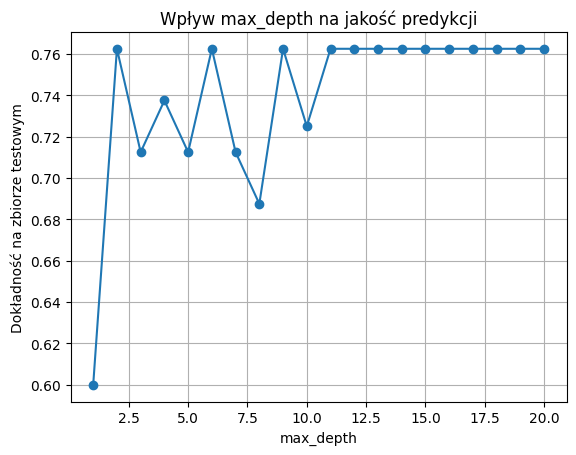

In [28]:
depths = list(range(1, 21))
scores_depth = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(X_train_full, y_train_full)
    scores_depth.append(clf.score(X_test, y_test))

plt.plot(depths, scores_depth, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Dokładność na zbiorze testowym")
plt.title("Wpływ max_depth na jakość predykcji")
plt.grid()
plt.show()

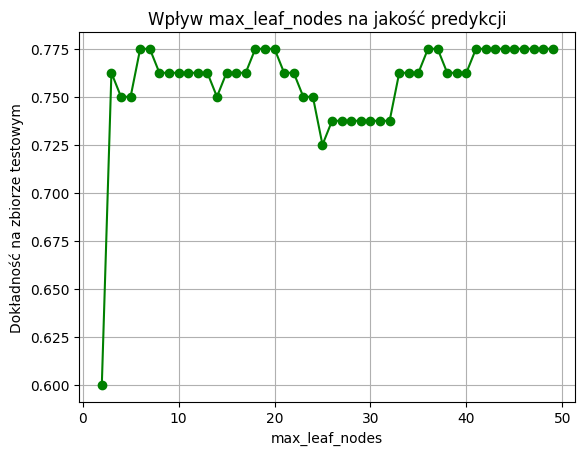

In [29]:
leaf_nodes = list(range(2, 50))
scores_leaf = []

for l in leaf_nodes:
    clf = DecisionTreeClassifier(max_leaf_nodes=l, random_state=0)
    clf.fit(X_train_full, y_train_full)
    scores_leaf.append(clf.score(X_test, y_test))

plt.plot(leaf_nodes, scores_leaf, marker='o', color='green')
plt.xlabel("max_leaf_nodes")
plt.ylabel("Dokładność na zbiorze testowym")
plt.title("Wpływ max_leaf_nodes na jakość predykcji")
plt.grid()
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_clf.fit(X_train_full, y_train_full)
y_test_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_test_pred_rf)
print("Dokładność RandomForestClassifier:", acc_rf)

Dokładność RandomForestClassifier: 0.775


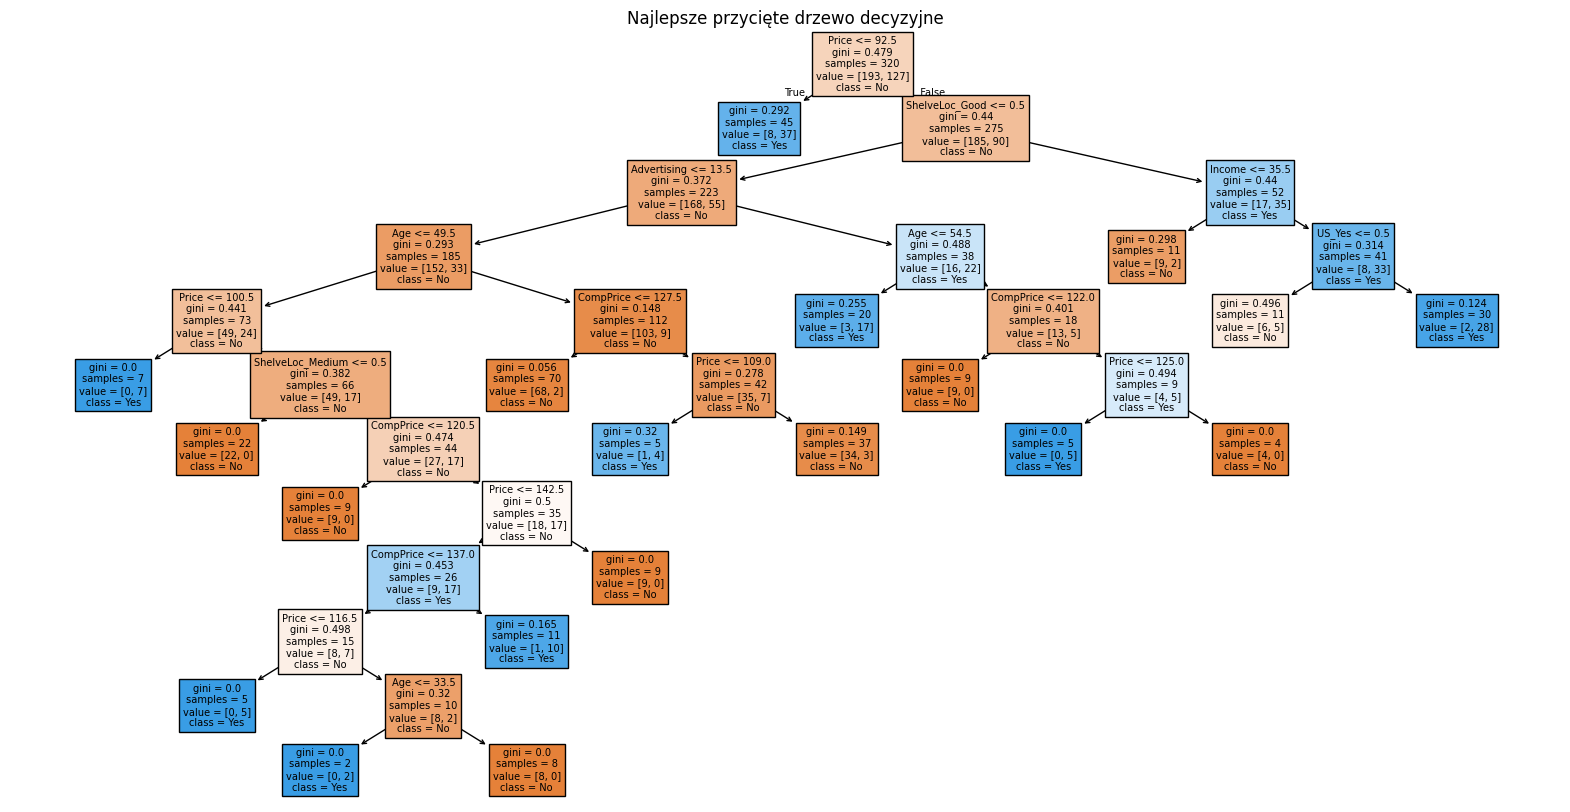

In [31]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(clf_pruned, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.title("Najlepsze przycięte drzewo decyzyjne")
plt.show()


In [32]:
from sklearn.metrics import classification_report

print("Ewaluacja końcowego drzewa (przycinanego):")
print(classification_report(y_test, clf_pruned.predict(X_test)))

Ewaluacja końcowego drzewa (przycinanego):
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        43
           1       0.74      0.84      0.78        37

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80

